In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class GraphClass:
    def __init__(self, graph):
        print(graph)
        self.graph = graph

        # create adjacency matrix
        self.adj_matrix = nx.to_numpy_array(self.graph)

        # == nodes ==
        # degree
        self.degrees = self.adj_matrix.sum(axis=1).reshape((-1, 1))

        # opinion
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

        # conformity
        self.conformity = np.array(list(nx.get_node_attributes(self.graph, "conformity").values())).reshape((-1, 1))

        # node_centrality
        self.node_centrality = np.array(list(nx.get_node_attributes(self.graph, "node_centrality").values())).reshape((-1, 1))
        
        # == edges ==
        # weight on edges
        self.weight = nx.attr_matrix(self.graph, edge_attr='weight')[0]


In [3]:
class ExperimentClass(GraphClass):
    def __init__(self, graph: nx.Graph, model_name: str):
        super().__init__(graph)
        self.model_name = model_name
        self.opinions_per_iter = []

    def run_model(self, steps: int):
        self.initial_opinions = self.opinions.copy()

        for _ in range(1, steps):
            if self.model_name == 'FJ':
                w_ii = np.diag(self.weight).reshape((-1, 1)) # weights on self-loop edges
                new_opinions = (1 - w_ii) * (self.adj_matrix * self.weight @ self.opinions) + (w_ii * self.initial_opinions)
            elif self.model_name == 'Abebe':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ self.opinions) / (self.degrees + 0.001)
            elif self.model_name == 'new':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix @ (self.node_centrality * self.opinions)) / ((self.adj_matrix @ self.node_centrality) + 0.001)

            self._update_graph(new_opinions)
            self.opinions_per_iter.append(new_opinions)

    def _update_graph(self, new_opinions):
        for i, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['opinion'] = new_opinions[i][0]
        
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

    def plot(self):
        # plot each time of sum of opinions
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.array(self.opinions_per_iter).sum(axis=1))
        ax.set_xlabel('time')
        ax.set_ylabel('sum of opinions')
        ax.set_title(f'Sum of opinions over time ({self.model_name})')
        plt.show()

    def get_opinions_per_iter(self):
        return self.opinions_per_iter

In [5]:
from read_networks import read_combined_graph_from_csv, read_citation_graph_from_edgelist

# create random graph
# g = nx.erdos_renyi_graph(n=100, p=0.5, seed=42)  # random graph
#g = read_citation_graph_from_edgelist (field='History', graph=nx.Graph())
g_simple, g_init, df = read_combined_graph_from_csv(field='History', init_cutoff_date = '2019-03-31', graph=nx.Graph())
print(g_simple)
print(g_init)

Graph with 11870 nodes and 19683 edges
Graph with 11870 nodes and 943 edges


In [6]:
# add node properties such as weight and opinion

for node in g_simple.nodes:
    g_simple.nodes[node]['opinion'] = 0

# Initialize with a given timpstamp.
# If nodes are connected before this timestamp, they share a same init opinion.
for node in g_simple.nodes:
    has_opinion_flag = False
    for init_nbr in g_init.neighbors(node):
        if g_simple.nodes[init_nbr]['opinion'] != 0:
            g_simple.nodes[node]['opinion'] = g_simple.nodes[init_nbr]['opinion']
            has_opinion_flag = True
            break
    if not has_opinion_flag:
        g_simple.nodes[node]['opinion'] = np.random.rand()
    print(g_simple.nodes[node]['opinion'])

    g_simple.nodes[node]['conformity'] = np.random.rand()
    g_simple.nodes[node]['node_centrality'] = 0.01 + g_init.degree(node) # approx by citations
    

# add edge weight
for e1, e2 in g_simple.edges:
    g_simple.edges[e1, e2]['weight'] = np.random.rand()

# # display thier properties
# for node in g.nodes:
#     print(g.nodes[node])

0.5251748794294214
0.5251748794294214
0.15040775026447162
0.15040775026447162
0.15040775026447162
0.8349783848355951
0.8349783848355951
0.8349783848355951
0.8349783848355951
0.22996331684872606
0.22996331684872606
0.17008500135844062
0.17008500135844062
0.17008500135844062
0.17008500135844062
0.17008500135844062
0.17008500135844062
0.009575045316646102
0.009575045316646102
0.932109511386102
0.932109511386102
0.40962777981078624
0.40962777981078624
0.40962777981078624
0.4817564522428228
0.4817564522428228
0.16077020037181244
0.16077020037181244
0.4405549292875144
0.4405549292875144
0.4405549292875144
0.12763282311888058
0.12763282311888058
0.12763282311888058
0.07005769085848346
0.07005769085848346
0.07005769085848346
0.12307006660998854
0.12307006660998854
0.13290055744455131
0.13290055744455131
0.5739964616629367
0.5739964616629367
0.5739964616629367
0.5739964616629367
0.633762304162752
0.633762304162752
0.4570712318736194
0.4570712318736194
0.4570712318736194
0.894577754044592
0.8945

0.3075704793273346
0.5344344761989434
0.585814102773482
0.9708755109439798
0.5035728900981186
0.4226802307433548
0.3195062599323004
0.3995871909199721
0.761350580753462
0.43484489181055264
0.43559211041532664
0.680250015151691
0.8323002821810717
0.5165671774782639
0.5086107263789177
0.5563948497606175
0.3201999121569151
0.8648141762112523
0.6197354085596756
0.7911601393705967
0.5901742319433279
0.7938129022438598
0.7266005787988783
0.5082003296259828
0.6166944137195797
0.28726791295448506
0.6715876249615472
0.502426664078742
0.574530287270249
0.587822395784325
0.1893801438247893
0.004512735746257324
0.4859647710780305
0.7101982193285736
0.27713698924644914
0.10046793141073362
0.7217305752889048
0.38686606551345504
0.9557246254996311
0.6659143830844957
0.19361344267609193
0.8504035541807813
0.680850689219056
0.045889626172362696
0.5540510463217015
0.17766132114050792
0.1013445256946427
0.3678295172931988
0.6758419444992885
0.892849604404165
0.8851640664640871
0.14077385355364724
0.84125

0.21443346918834383
0.687656868021419
0.38381110174078426
0.8674094148490383
0.6314186995531762
0.6098461791812794
0.3052333344938529
0.15787309149386208
0.9444460564886755
0.025954468831757005
0.3896312182829963
0.5180613599099243
0.45316886201733564
0.830557016220699
0.6735245050134209
0.2356697865539491
0.7817805989264354
0.9366539335456456
0.35834483985374155
0.3784068148239649
0.38503329808562725
0.15325400631779362
0.12682187057412397
0.9912734268860732
0.7020371942091082
0.24734746475483593
0.8532815835159089
0.9779801346692418
0.7360704321673582
0.4421724456433008
0.822947786322392
0.3468124710963253
0.3196363068336485
0.3744238090953571
0.7760349335403859
0.13286990735106974
0.004843328703647787
0.8208723810970954
0.8970723532000694
0.13019777250107878
0.5933328227588637
0.8010877001156793
0.21551327016794553
0.7784891731335102
0.14203481129971807
0.05547642403691433
0.12802320913782272
0.28397395576254825
0.8124639186904251
0.4967528408383153
0.6352064057079362
0.028285815424

0.19935441430771728
0.7847371002418825
0.2671183594686952
0.13469706312994
0.9686821914990288
0.9237588809301203
0.831248671623665
0.1299563583523734
0.4723411931349375
0.03725723700193173
0.2137786578431703
0.6705564682338825
0.24234377624689263
0.3159238433581987
0.5053032122454072
0.14510786855452096
0.32594482088540266
0.612069083262129
0.35773698122562747
0.20985401558202066
0.5967570426558043
0.9768435566637156
0.6949306561479957
0.363110158537184
0.0984065188736234
0.5073221878790029
0.6819374827781012
0.17650925540837425
0.8693861552730039
0.15184787971003122
0.0023465819739008076
0.3727025412631598
0.7538567751991094
0.1521042836509654
0.377808058789324
0.3451322529566495
0.43602788534315406
0.39156844329406404
0.29318885057177435
0.31415340452735385
0.48512953536203973
0.8685205960699075
0.6332987455215643
0.3241990325039461
0.9771393917774501
0.22673490217928172
0.47894177214788924
0.6821844554669231
0.7721619113025364
0.9766086382239052
0.6600121413146621
0.2031468315394596

0.5895306079490781
0.27184358793772045
0.20855534621392313
0.9589682018846096
0.9393337144892779
0.5954659346940391
0.07461660733576247
0.4776269750719836
0.16057875696752788
0.29258069451254753
0.5580089327215972
0.9805941422386026
0.4046785442157915
0.16901177927190092
0.11307373140308041
0.9825335724929349
0.21641774607411346
0.06380915619603611
0.7819520820331456
0.2629525542407799
0.31293311252029377
0.6268416796122867
0.3535427994040353
0.5554630370252627
0.11213125578392891
0.33722036479884077
0.5074410627158535
0.7932022290069658
0.12352919920045236
0.2728341626765043
0.9081088413490405
0.3455591530570109
0.7613305013289606
0.5577614468125375
0.2750013082051064
0.8323695297613722
0.45986797437416527
0.700169524432253
0.5538310158431196
0.17164109318883802
0.7049859036618799
0.16346059104153554
0.0573322469608496
0.30088431252694503
0.5605795877819052
0.9449923526874273
0.19506968275323433
0.30403784681042834
0.7075801464076176
0.5050045355453626
0.39075375653316513
0.3231141800

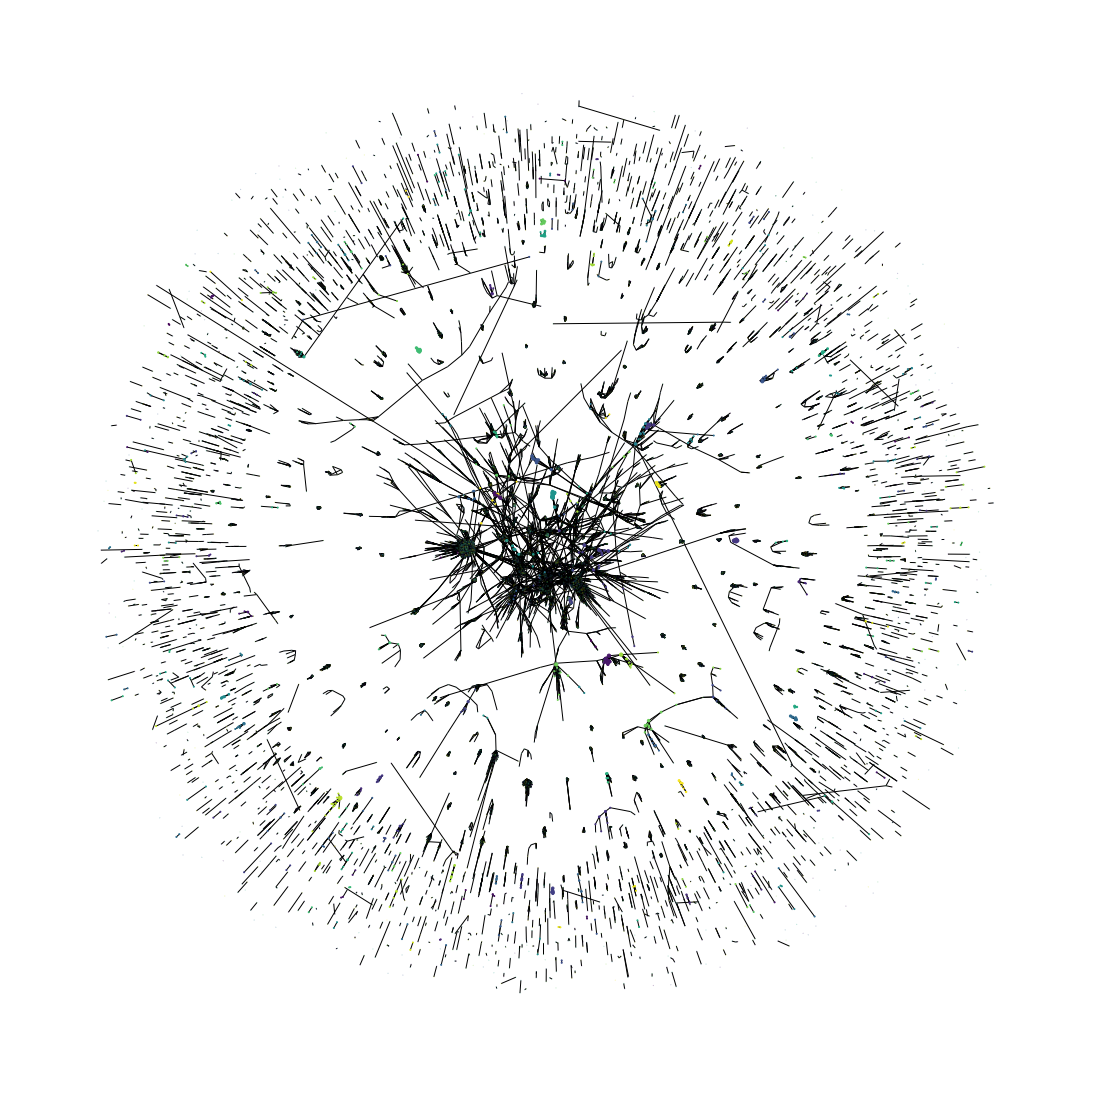

In [7]:
plt.figure(figsize = (15,15))
nx.draw(g_simple, node_size=[g_simple.nodes[node]['node_centrality'] for node in g_simple.nodes],
    node_color=[g_simple.nodes[node]['opinion'] for node in g_simple.nodes])
plt.savefig('start.svg')

Graph with 11870 nodes and 19683 edges


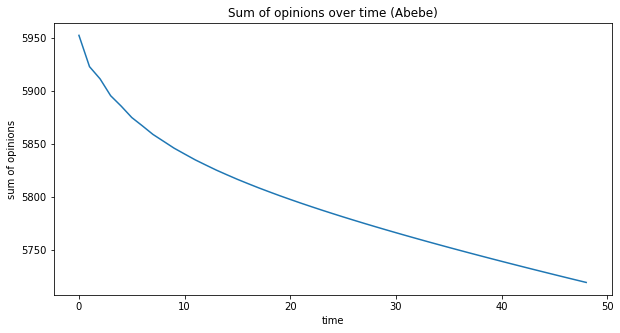

In [8]:
test = ExperimentClass(g_simple, 'Abebe')
test.run_model(50)
test.plot()

Graph with 11870 nodes and 19683 edges


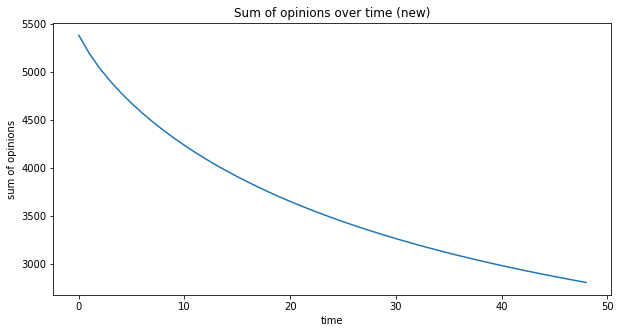

In [9]:
test = ExperimentClass(g_simple, 'new')
test.run_model(50)
test.plot()